# 2025年度 採用課題: 表情推定によるマーケティング調査

このノートブックでは、**`smile_predict`** 関数の実装および評価用スケルトンのみを用意しています。  
以下のセルをベースに、自由に追加セルを作成して実験・検証を行ってください。

---

### TODO
- `smile_predict` を実装して笑顔判定ロジックを完成させる  
- 評価セルを実行し **Train / Test accuracy** を確認する

※注意：実行はこのipynbファイルだけで完結する形にしてください。

（学習済みモデルを外部へ一時的に保存して、再度参照等は×）

In [20]:
# 最小実装の smile_predict を先頭付近に定義します。
# 優先: ノートブック内で決定された best_param を使う。
# 代替: もし学習済みの LogisticRegression (clf_lr) と scaler があればそれを使う。
def smile_predict(points):
    """points: list of 15 (x,y) landmarks (s[1:-1] の形式)。"""
    # 口のランドマーク (1-based index に基づく)
    left = points[12-1]; right = points[13-1]; top = points[14-1]; bottom = points[15-1]
    mouth_w = abs(right[0] - left[0])
    mouth_h = abs(bottom[1] - top[1])
    ratio = mouth_h / mouth_w if mouth_w > 0 else 0.0
    # 1) best_param があれば閾値ルールを優先して使う
    if 'best_param' in globals() and best_param is not None:
        r, w = best_param
        return (ratio > r) and (mouth_w > w)
    # 2) clf_lr と scaler が既に定義されているならモデル予測を使う
    if 'clf_lr' in globals() and 'scaler' in globals():
        try:
            feat = compute_features(points)
            x_s = scaler.transform([feat])
            return bool(clf_lr.predict(x_s)[0])
        except Exception:
            pass
    # 3) フォールバックの単純ルール
    return (ratio > 0.20) and (mouth_w > 30.0)

---

## 次のステップ
1. (optional)上記の `smile_predict` を改良し、ビジネス要件（軽量・高速）を満たしつつ精度を高めてください  
2. 上記分析の結果を、`smile_detection_report.pdf` としてレポートにまとめましょう。
3. 上記の`smile_detection_report.pdf`と こちらの**`coding_test_smile_detection.ipynb`** を共有リンク内の提出フォルダへ配置し、メールにてご一報いただければと思います。

## 1) ライブラリとデータ読み込み

In [12]:
## ============================================================
## 1) ライブラリとデータ読み込み
## - facial_keypoints.json から train/test をロード
## - 乱数シードを固定して再現性を確保
## ============================================================
import json
from pathlib import Path
import random
random.seed(42)
import math
import numpy as np
import matplotlib.pyplot as plt

data_path = Path('data') / 'facial_keypoints.json'
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
train = data['train']
test  = data['test']
print('Loaded', len(train), 'train samples,', len(test), 'test samples')


# train を train_split / val_split に分割（80/20）
import random
random.seed(42)
indices = list(range(len(train)))
random.shuffle(indices)
split_idx = int(len(indices) * 0.8)
train_idx = indices[:split_idx]
val_idx   = indices[split_idx:]
train_split = [train[i] for i in train_idx]
val_split   = [train[i] for i in val_idx]



Loaded 657 train samples, 282 test samples


## 2) EDA－直観的特徴の計算路ヒストグラム（mouth_width, mouth?height, ratio ）

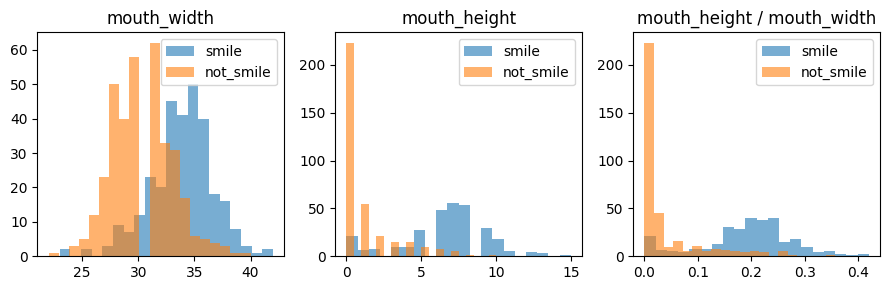

In [13]:

def calc_features_from_points(points):
    # 口のランドマーク（データは1始まりのインデックス）
    left  = points[12-1]
    right = points[13-1]
    top   = points[14-1]
    bottom= points[15-1]
    # 口の横幅（x座標の差の絶対値）
    mouth_width = abs(right[0] - left[0])
    # 口の縦幅（y座標の差の絶対値）
    mouth_height = abs(bottom[1] - top[1])
    # 横幅に対する高さの比率（開き具合）
    ratio = mouth_height / mouth_width if mouth_width > 0 else 0.0
    return mouth_width, mouth_height, ratio

# 格納リスト
ratio_smile = []
ratio_not_smile = []
width_smile = []
width_not_smile = []
height_smile = []
height_not_smile = []

# train データを使って ratio を計算
for s in train:
    pts = s[1:-1]
    mw, mh, r = calc_features_from_points(pts)
    if s[-1]['smile']:
        ratio_smile.append(r); width_smile.append(mw); height_smile.append(mh)
    else:
        ratio_not_smile.append(r); width_not_smile.append(mw); height_not_smile.append(mh)

# ヒストグラム描画mouth_width
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.hist(width_smile, bins=20, alpha=0.6, label='smile')
plt.hist(width_not_smile, bins=20, alpha=0.6, label='not_smile')
plt.title('mouth_width')
plt.legend()

# ヒストグラム描画mouth_height
plt.subplot(1,3,2)
plt.hist(height_smile, bins=20, alpha=0.6, label='smile')
plt.hist(height_not_smile, bins=20, alpha=0.6, label='not_smile')
plt.title('mouth_height')
plt.legend()

# ヒストグラム描画hw_ratio
plt.subplot(1,3,3)
plt.hist(ratio_smile, bins=20, alpha=0.6, label='smile')
plt.hist(ratio_not_smile, bins=20, alpha=0.6, label='not_smile')
plt.title('mouth_height / mouth_width')
plt.legend()

plt.tight_layout()
plt.show()

## 3) 誤り解析 — FP / FN の列挙と可視化
以下のセルでは、`val_split`（存在する場合）を優先して使用し、誤分類（False Positive / False Negative）を列挙して代表例を `plot_face` で可視化します。

誤分類数: FP=5, FN=14, dataset_size=132
[{'gt': 0,
  'id': 'n554wzmEkT',
  'mouth_h': 6,
  'mouth_w': 27,
  'pred': 1,
  'ratio': 0.2222222222222222},
 {'gt': 0,
  'id': 'zfzRN2ikHE',
  'mouth_h': 7,
  'mouth_w': 27,
  'pred': 1,
  'ratio': 0.25925925925925924},
 {'gt': 0,
  'id': 'kPMdXdTUyY',
  'mouth_h': 8,
  'mouth_w': 30,
  'pred': 1,
  'ratio': 0.26666666666666666},
 {'gt': 0,
  'id': 'rH0Fyytqcu',
  'mouth_h': 4,
  'mouth_w': 29,
  'pred': 1,
  'ratio': 0.13793103448275862},
 {'gt': 0,
  'id': 'hHhFf8N4Hk',
  'mouth_h': 7,
  'mouth_w': 34,
  'pred': 1,
  'ratio': 0.20588235294117646}]
[{'gt': 1,
  'id': 'G75cwQBYD1',
  'mouth_h': 5,
  'mouth_w': 38,
  'pred': 0,
  'ratio': 0.13157894736842105},
 {'gt': 1,
  'id': '6nwavsNfWR',
  'mouth_h': 4,
  'mouth_w': 36,
  'pred': 0,
  'ratio': 0.1111111111111111},
 {'gt': 1,
  'id': 'CcTYoa6pky',
  'mouth_h': 4,
  'mouth_w': 30,
  'pred': 0,
  'ratio': 0.13333333333333333},
 {'gt': 1,
  'id': '3iAUO79ArL',
  'mouth_h': 0,
  'mouth_w': 34,
  'p

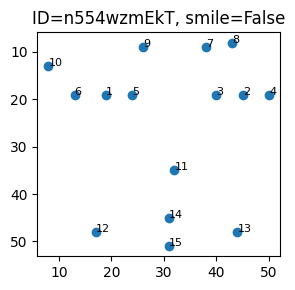

FP #2 id=zfzRN2ikHE


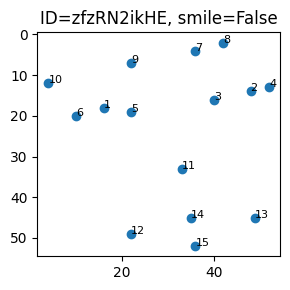

FP #3 id=kPMdXdTUyY


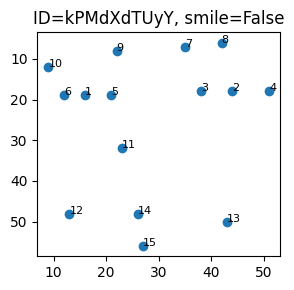

--- FN examples ---
FN #1 id=G75cwQBYD1


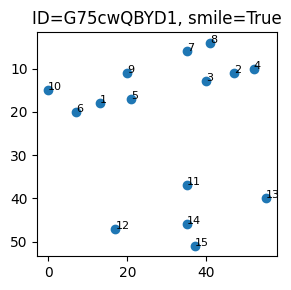

FN #2 id=6nwavsNfWR


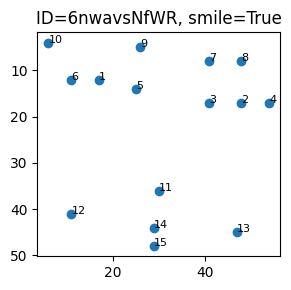

FN #3 id=CcTYoa6pky


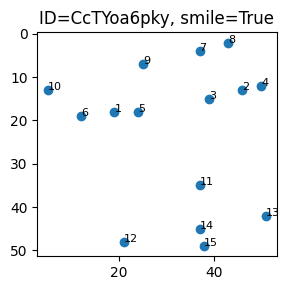

In [22]:
## ============================================================
## 3) 誤り解析: False Positive / False Negative の可視化
## - FP / FN を厳密に排他的に分類
## - 特徴量計算は一度だけ行い、rows にも同じ値を格納
## ============================================================

# データセットを明示的にval_splitに決定（testを使う時は置換すれば良い）
if 'val_split' not in globals():
    raise RuntimeError("val_split が定義されていません。前のセルを実行してください。")
dataset = val_split

# smile_predict が定義されているかチェック
if 'smile_predict' not in globals():
    raise RuntimeError('`smile_predict` が未定義です。このセルを実行する前に、実装・定義してください。')

fp = []  # pred True, gt False
fn = []  # pred False, gt True
rows = []  # for later analysis / plotting

def calc_mouth_features(pts):
    """口周りの簡易特徴量を計算するユーティリティ."""
    left   = pts[12-1]
    right  = pts[13-1]
    top    = pts[14-1]
    bottom = pts[15-1]
    mouth_w = abs(right[0] - left[0])
    mouth_h = abs(bottom[1] - top[1])
    ratio = mouth_h / mouth_w if mouth_w > 1e-6 else 0.0
    return mouth_w, mouth_h, ratio

for s in dataset:
    pts = s[1:-1]
    gt = bool(s[-1]['smile'])  # True / False に正規化

    # モデルによる予測（例外はその場で検知してエラーを投げる）
    try:
        pred = bool(smile_predict(pts))
    except Exception as e:
        raise RuntimeError(f"smile_predict failed for id={s[0]}: {e}")

    # FP / FN の排他的分類
    if pred == gt:
        pass  # 正解なので何もしない
    elif pred and not gt:
        fp.append(s)
    else:  # (not pred) and gt
        fn.append(s)

    # 特徴量を一度だけ計算し、行として保存
    mouth_w, mouth_h, ratio = calc_mouth_features(pts)
    rows.append({
        'id': s[0],
        'pred': int(pred),
        'gt': int(gt),
        'mouth_w': mouth_w,
        'mouth_h': mouth_h,
        'ratio': ratio,
    })

print(f'誤分類数: FP={len(fp)}, FN={len(fn)}, dataset_size={len(dataset)}')
fp_rows = [r for r in rows if r['pred'] == 1 and r['gt'] == 0]
from pprint import pprint
pprint(fp_rows)
fn_rows = [r for r in rows if r['pred'] == 0 and r['gt'] == 1]
pprint(fn_rows)


# 表示: 最初の数個を plot_face で可視化
# 顔のランドマークを散布図で描画する簡易関数
def plot_face(sample, title=None):
    """
    sample: [id, p1, p2, ..., p15, {'smile': bool}]
    顔の15点ランドマークを散布図で描画する簡易関数。
    """
    pts = sample[1:-1]  # ランドマーク座標 [(x, y), ...]
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]

    plt.figure(figsize=(3, 3))
    plt.scatter(xs, ys)
    # 点番号を表示（デバッグ用）
    for i, (x, y) in enumerate(pts, start=1):
        plt.text(x, y, str(i), fontsize=8)
    plt.gca().invert_yaxis()  # 画像座標系に合わせる
    if title is None:
        title = f"ID={sample[0]}, smile={sample[-1]['smile']}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

n_show = 3
print('--- FP examples ---')
for i, s in enumerate(fp[:n_show], start=1):
    print(f'FP #{i} id={s[0]}')
    try:
        plot_face(s)
    except Exception as e:
        print(f'plot_face error (FP id={s[0]}):', e)

print('--- FN examples ---')
for i, s in enumerate(fn[:n_show], start=1):
    print(f'FN #{i} id={s[0]}')
    try:
        plot_face(s)
    except Exception as e:
        print(f'plot_face error (FN id={s[0]}):', e)

## 4) ベースライン: 閾値ルールの検証（train→train/val 分割、validation で選定）

In [23]:
# --- データセット上の閾値での評価関数 ---
def eval_on_dataset(th_ratio, th_width, dataset):
    correct = 0
    total = 0
    for sample in dataset:
        pts = sample[1:-1]
        # 明示的に left/right/top/bottom を使って正しい幅・高さを計算
        left   = pts[12-1]
        right  = pts[13-1]
        top    = pts[14-1]
        bottom = pts[15-1]
        mouth_width = abs(right[0] - left[0])
        mouth_height = abs(bottom[1] - top[1])
        ratio = mouth_height / mouth_width if mouth_width > 0 else 0.0
        pred = (ratio > th_ratio) and (mouth_width > th_width)
        gt = sample[-1]['smile']
        if pred == gt:
            correct += 1
        total += 1
    return correct / total if total>0 else 0.0

# --- グリッド探索（validation のみで選択） ---
ratios = [0.135, 0.20, 0.21, 0.22, 0.23, 0.24]
widths = [22.5, 30.0, 30.5, 31.0, 31.5, 32.0]
best_val = -1
best_param = None
for r in ratios:
    for w in widths:
        acc = eval_on_dataset(r, w, val_split)
        if acc > best_val:
            best_val = acc; best_param = (r, w)
        print(f'val r={r:.3f} w={w:.1f} -> {acc:.4f}')

print('BEST on val:', best_param, best_val)

# 最終評価:選ばれた閾値を train_split / full train / test に適用 ---
if best_param is not None:
    tr_acc = eval_on_dataset(best_param[0], best_param[1], train_split)
    full_acc = eval_on_dataset(best_param[0], best_param[1], train)
    test_acc = eval_on_dataset(best_param[0], best_param[1], test)
    print('Train_split acc:', tr_acc)
    print('Full_train  acc:', full_acc)
    print('Test        acc:', test_acc)

val r=0.135 w=22.5 -> 0.8561
val r=0.135 w=30.0 -> 0.8333
val r=0.135 w=30.5 -> 0.8333
val r=0.135 w=31.0 -> 0.8182
val r=0.135 w=31.5 -> 0.8182
val r=0.135 w=32.0 -> 0.8030
val r=0.200 w=22.5 -> 0.7045
val r=0.200 w=30.0 -> 0.6894
val r=0.200 w=30.5 -> 0.6894
val r=0.200 w=31.0 -> 0.6742
val r=0.200 w=31.5 -> 0.6742
val r=0.200 w=32.0 -> 0.6591
val r=0.210 w=22.5 -> 0.7045
val r=0.210 w=30.0 -> 0.6894
val r=0.210 w=30.5 -> 0.6894
val r=0.210 w=31.0 -> 0.6742
val r=0.210 w=31.5 -> 0.6742
val r=0.210 w=32.0 -> 0.6591
val r=0.220 w=22.5 -> 0.6515
val r=0.220 w=30.0 -> 0.6515
val r=0.220 w=30.5 -> 0.6515
val r=0.220 w=31.0 -> 0.6364
val r=0.220 w=31.5 -> 0.6364
val r=0.220 w=32.0 -> 0.6288
val r=0.230 w=22.5 -> 0.6136
val r=0.230 w=30.0 -> 0.6061
val r=0.230 w=30.5 -> 0.6061
val r=0.230 w=31.0 -> 0.5985
val r=0.230 w=31.5 -> 0.5985
val r=0.230 w=32.0 -> 0.5909
val r=0.240 w=22.5 -> 0.5682
val r=0.240 w=30.0 -> 0.5758
val r=0.240 w=30.5 -> 0.5758
val r=0.240 w=31.0 -> 0.5682
val r=0.240 w=

## 5) 特徴設計（安定版 compute_features） — スケール正規化を含む

In [16]:
## ============================================================
## 5) 特徴設計: compute_features (スケール正規化付き)
## - 顔全体サイズで正規化した「口の開き」「左右差」等を計算
## - 目的:
##   - モデルベース手法（Logistic / RF）で
##     どの特徴が有効かを定量的に評価する
## ============================================================

from dataclasses import dataclass
@dataclass
class LM:
    mouth_left_idx: int = 12
    mouth_right_idx: int = 13
    mouth_top_idx: int = 14
    mouth_bottom_idx: int = 15

def safe_div(a,b,eps=1e-6):
    return a/b if abs(b)>eps else 0.0

def compute_features(points, lm=LM()):
    left  = points[lm.mouth_left_idx-1]
    right = points[lm.mouth_right_idx-1]
    top   = points[lm.mouth_top_idx-1]
    bottom= points[lm.mouth_bottom_idx-1]
    xs = [p[0] for p in points]; ys = [p[1] for p in points]
    face_w = max(xs)-min(xs); face_h = max(ys)-min(ys)
    face_scale = max(face_w, face_h, 1e-6)
    mouth_w = math.dist(left, right)
    mouth_h = abs(bottom[1]-top[1])
    mouth_openness = safe_div(mouth_h, face_scale)
    mouth_hw_ratio = safe_div(mouth_h, mouth_w)
    mouth_w_over_face = safe_div(mouth_w, face_w)
    corner_asym = safe_div(abs(left[1]-right[1]), face_scale)
    left_corner_lift = safe_div(top[1]-left[1], mouth_w)
    right_corner_lift = safe_div(top[1]-right[1], mouth_w)
    cheek_lift_mean = 0.0
    eye_left_open = 0.0
    eye_right_open = 0.0
    size_feature = face_scale
    feats = [mouth_openness, mouth_hw_ratio, mouth_w_over_face, mouth_h/face_h if face_h>0 else 0.0, corner_asym, left_corner_lift, right_corner_lift, cheek_lift_mean, eye_left_open, eye_right_open, size_feature]
    return np.array(feats, dtype=float)

# quick sanity check(特徴量の定義が健全に動作しているかチェック)
X0 = compute_features(train[0][1:-1])
print('feature vector length:', len(X0),',成功')

# helper: build (X, y) from dataset using compute_features（train/val/testをMLモデルに入力できる形式に変換する関数）
def build_Xy(dataset):
    """Convert dataset (list of samples) to (X, y)."""
    X = []
    y = []
    for s in dataset:
        # s: [id, p1, p2, ..., p15, {'smile': bool}]
        X.append(compute_features(s[1:-1]))  # 15点→特徴量ベクトル
        y.append(1 if s[-1]['smile'] else 0)  # True/False → 1/0
    return np.vstack(X), np.array(y)

feature vector length: 11 ,成功


## 6) モデル: ロジスティック回帰（係数で特徴精査）と RandomForest の比較

In [24]:
## ============================================================
## モデル比較: ロジスティック回帰 vs RandomForest
## - 特徴量:　セクション5で作成した compute_features() で設計した 11 次元特徴
## - 目的: 閾値ルールの妥当性チェック / 特徴量の重要度確認
## ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# train / val / full / test それぞれを行列形式に変換
X_train, y_train = build_Xy(train_split)
X_val, y_val = build_Xy(val_split)
X_full, y_full = build_Xy(train)
X_test, y_test = build_Xy(test)

## ロジスティック回帰（各特徴量をスケール正規化（平均０,分散１） + C の簡易サーチ）
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_full_s = scaler.transform(X_full)
X_test_s = scaler.transform(X_test)

# Logistic Regression (simple C sweep)
best_c = None
best_val_acc = -1.0

for C in [0.01, 0.1, 1.0, 10.0]:
    clf = LogisticRegression(C=C, max_iter=1000)
    clf.fit(X_train_s, y_train)
    val_acc = accuracy_score(y_val, clf.predict(X_val_s))
    print(f'LR C={C}, val_acc={val_acc:.4f}')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_c = C


clf_lr = LogisticRegression(C=best_c, max_iter=1000)
clf_lr.fit(X_train_s, y_train)

print('LR train acc', accuracy_score(y_train, clf_lr.predict(X_train_s)))
print('LR val   acc', accuracy_score(y_val, clf_lr.predict(X_val_s)))
print('LR test  acc', accuracy_score(y_test, clf_lr.predict(X_test_s)))
print('LR coeffs:', clf_lr.coef_)


## RandomForest: GridSearchCV によるハイパーパラメータ探索
# NOTE: 実行時間が長くなるため、このセルは分析用です。必要な場合のみ実行してください。
# 以下は提出用に軽量化した探索設定です（組合せ数を絞り、学習回数を削減）。
rf_base = RandomForestClassifier(
     random_state=42,
    class_weight="balanced"  # クラス不均衡への耐性
)
param_grid = {
    "n_estimators":     [100, 200],
    "max_depth":        [4, 6, None],
    "min_samples_leaf": [1, 3],
    "max_features":     ["sqrt", None]
}
# CV を 3 分割にして実行時間をさらに短縮（デフォルトは 5）
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring="accuracy",
    n_jobs=-1,
    cv=cv,
    verbose=1
)

# 今回は train_split の特徴量を使ってチューニング
grid.fit(X_train, y_train)

print("Best RF CV accuracy:", grid.best_score_)
print("Best RF parameters:", grid.best_params_)

best_rf = grid.best_estimator_
best_rf.fit(X_full, y_full)  # train 全体で再学習

y_pred_train_best = best_rf.predict(X_full)
y_pred_test_best  = best_rf.predict(X_test)

print(f"\n[Best RF] Train accuracy: {accuracy_score(y_full, y_pred_train_best):.4f}")
print(f"[Best RF] Test  accuracy: {accuracy_score(y_test,  y_pred_test_best):.4f}")
print("\nConfusion matrix (test):")
print(confusion_matrix(y_test, y_pred_test_best))

## 特徴量名（compute_features の順番に対応）
FEATURE_NAMES = [
    "mouth_openness",       # mouth_h / face_scale
    "mouth_hw_ratio",       # mouth_h / mouth_w
    "mouth_w_over_face",    # mouth_w / face_w
    "mouth_h_over_face_h",  # mouth_h / face_h
    "corner_asym",          # mouth corner y 差
    "left_corner_lift",
    "right_corner_lift",
    "cheek_lift_mean",
    "eye_left_open",
    "eye_right_open",
    "face_scale"
]

importances = best_rf.feature_importances_
order = np.argsort(importances)[::-1]

print("\nFeature importances (Best RF):")
for idx in order:
    print(f"{FEATURE_NAMES[idx]:20s}: {importances[idx]:.4f}")

LR C=0.01, val_acc=0.9091
LR C=0.1, val_acc=0.9470
LR C=1.0, val_acc=0.9470
LR C=10.0, val_acc=0.9318
LR train acc 0.9142857142857143
LR val   acc 0.946969696969697
LR test  acc 0.9148936170212766
LR coeffs: [[0.75708231 0.45780175 1.14951699 0.84020636 0.07836864 0.16695587
  0.43384914 0.         0.         0.         0.4517059 ]]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\Kouki\entry-scien\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF CV accuracy: 0.9028571428571429
Best RF parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 200}

[Best RF] Train accuracy: 0.9543
[Best RF] Test  accuracy: 0.9149

Confusion matrix (test):
[[120   9]
 [ 15 138]]

Feature importances (Best RF):
mouth_h_over_face_h : 0.2951
mouth_openness      : 0.2077
mouth_hw_ratio      : 0.1706
mouth_w_over_face   : 0.1647
right_corner_lift   : 0.0564
left_corner_lift    : 0.0430
face_scale          : 0.0362
corner_asym         : 0.0263
eye_right_open      : 0.0000
eye_left_open       : 0.0000
cheek_lift_mean     : 0.0000


## 7) smile_predict関数の調整と実装

In [18]:
# 最終版 smile_predict
def smile_predict(points):
    """
    points: list of 15 (x, y) landmarks (s[1:-1] の形式)

    優先順位:
      1) Logistic Regression + scaler が定義されていれば、それを使う
      2) なければ、(ratio, width) の閾値ルールで判定
    """

    # 1) 学習済み LogisticRegression モデルがある場合はそれを使う
    if 'clf_lr' in globals() and 'scaler' in globals():
        # compute_features で 11次元特徴ベクトルに変換
        feat = compute_features(points)              # shape: (11,)
        x_s = scaler.transform([feat])               # shape: (1,11)
        pred = clf_lr.predict(x_s)[0]                # 0 or 1
        return bool(pred)

    # 2) モデルが無い場合は、口の幾何特徴に基づく閾値ルールで判定
    left  = points[12-1]
    right = points[13-1]
    top   = points[14-1]
    bottom= points[15-1]

    mouth_w = abs(right[0] - left[0])
    mouth_h = abs(bottom[1] - top[1])
    ratio = mouth_h / mouth_w if mouth_w > 1e-6 else 0.0

    # val_split で探索した best_param があればそれを使う
    if 'best_param' in globals() and best_param is not None:
        th_ratio, th_width = best_param
    else:
        # グリッド探索結果からのデフォルト値（val ベスト）
        th_ratio = 0.135
        th_width = 22.5

    return (ratio > th_ratio) and (mouth_w > th_width)


In [19]:
# Test データに対する smile_predict の精度評価
correct = 0
total = len(test)

for s in test:
    pts = s[1:-1]                 # 15点ランドマーク
    gt = bool(s[-1]['smile'])     # Ground Truth (True/False)
    pred = bool(smile_predict(pts))

    if pred == gt:
        correct += 1

incorrect = total - correct
accuracy = correct / total * 100.0

print(f"Test 正解数    : {correct} / {total}")
print(f"Test 不正解数  : {incorrect} / {total}")
print(f"Test 精度      : {accuracy:.2f}%")


Test 正解数    : 258 / 282
Test 不正解数  : 24 / 282
Test 精度      : 91.49%
